In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from tqdm import tqdm
from matplotlib.lines import Line2D

from cryptic_rnn import *

# Functions

In [3]:
def run_exp(trainseqs_old ,trainseqs_old_b, trainseqs_old_p, trainseqs_old_bp, testseqs_old, cue_dict):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

    trainseqs = change_dict(trainseqs_old_b, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_b = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    trainseqs = change_dict(trainseqs_old_p, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_p = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    trainseqs = change_dict(trainseqs_old_bp, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_bp = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
        
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    model_b = copy.deepcopy(model)
    model_p = copy.deepcopy(model)
    model_bp = copy.deepcopy(model)
    criterion = nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs, hidden_size)
    
    optimizer = torch.optim.Adam(model_b.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model_b,optimizer,criterion, trainset_b, [trainset_b, testset], epochs, hidden_size)
    
    optimizer = torch.optim.Adam(model_p.parameters(), lr=learningRate)
    loss3, acc3 = run_acc(model_p,optimizer,criterion, trainset_p, [trainset_p, testset], epochs, hidden_size)
    
    optimizer = torch.optim.Adam(model_bp.parameters(), lr=learningRate)
    loss4, acc4 = run_acc(model_bp,optimizer,criterion, trainset_bp, [trainset_bp, testset], epochs, hidden_size)
       
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset,
           'loss_b':loss2, 'acc_b':acc2, 'mod_b': model_b,\
           'loss_p':loss3, 'acc_p':acc3, 'mod_p': model_p,\
           'loss_bp':loss4, 'acc_bp':acc4, 'mod_bp': model_bp}

def run_plot(trainseqs, trainseqs_b, trainseqs_p, trainseqs_bp, testseqs, cue_dict):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, trainseqs_b, trainseqs_p, trainseqs_bp,testseqs, cue_dict) for i in tqdm(range(num_sims)))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)
    
    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    
    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    
    losses_b = np.hstack([r['loss_b'] for r in res])
    acc_train_b = np.array([r['acc_b'][:,0] for r in res]).T
    acc_test_b = np.array([r['acc_b'][:,1] for r in res]).T
    mods_b = [r['mod_b'] for r in res]

    losses_p = np.hstack([r['loss_p'] for r in res])
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
    
    losses_bp = np.hstack([r['loss_bp'] for r in res])
    acc_train_bp = np.array([r['acc_bp'][:,0] for r in res]).T
    acc_test_bp = np.array([r['acc_bp'][:,1] for r in res]).T
    mods_bp = [r['mod_bp'] for r in res]
    
    plotNNs([losses], [acc_train, acc_test], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'no primitives', shift = 0)
    plotNNs([losses_b], [acc_train_b, acc_test_b], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'balanced -no primitives', shift = 0)
    plotNNs([losses_p], [acc_train_p, acc_test_p], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'with primitives', shift = 0)
    plotNNs([losses_bp], [acc_train_bp, acc_test_bp], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'balanced - with primitives', shift = 0)

    plt.figure()
    r2, dfs, _ = predcorr(mods, tests, hidden_size, plot_corr = True)
    plt.title('without primitives; r^2 = '+ str(round(r2, 3)))
    plt.figure()
    r2_b, dfs_b, _ = predcorr(mods_b, tests, hidden_size, plot_corr =True)
    plt.title('balanced-without primitives; r^2 = '+ str(round(r2_b, 3)))
    plt.figure()
    r2_p, dfs_p, _ = predcorr(mods_p, tests, hidden_size, plot_corr = True)
    plt.title('with primitives; r^2 = '+ str(round(r2_p, 3)))
    plt.figure()
    r2_bp, dfs_bp, _ = predcorr(mods_bp, tests, hidden_size, plot_corr =True)
    plt.title('balanced-with primitives; r^2 = '+ str(round(r2_bp, 3)))

    acc_df = pd.DataFrame({'acc_train': acc_train[-1,:], 'acc_train_b': acc_train_b[-1,:],\
                           'acc_train_p': acc_train_p[-1,:], 'acc_train_bp': acc_train_bp[-1,:],\
                           'acc_test': acc_test[-1,:], 'acc_test_b': acc_test_b[-1,:],\
                           'acc_test_p': acc_test_p[-1,:], 'acc_test_bp': acc_test_bp[-1,:]})
    
    return {'mods':mods, 'mods_b':mods_b, 'mods_p':mods_p, 'mods_bp':mods_bp, \
            'res':res, 'tests': tests, 'cue_dicts': cue_dicts, 'acc_df':acc_df }

def extract_loss(res):
    losses = np.hstack([r['loss'] for r in res])
    losses_b = np.hstack([r['loss_b'] for r in res])
    losses_p = np.hstack([r['loss_p'] for r in res])
    losses_bp = np.hstack([r['loss_bp'] for r in res])
    return {'losses':losses, 'losses_b':losses_b,'losses_p':losses_p, 'losses_bp':losses_bp}
    
def plot_traincurve(res):
    
    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    
    losses_b = np.hstack([r['loss_b'] for r in res])
    acc_train_b = np.array([r['acc_b'][:,0] for r in res]).T
    acc_test_b = np.array([r['acc_b'][:,1] for r in res]).T
    mods_b = [r['mod_b'] for r in res]

    losses_p = np.hstack([r['loss_p'] for r in res])
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
    
    losses_bp = np.hstack([r['loss_bp'] for r in res])
    acc_train_bp = np.array([r['acc_bp'][:,0] for r in res]).T
    acc_test_bp = np.array([r['acc_bp'][:,1] for r in res]).T
    mods_bp = [r['mod_bp'] for r in res]
    
    plotNNs([losses], [acc_train, acc_test], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'no primitives', shift = 0)
    plotNNs([losses_b], [acc_train_b, acc_test_b], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'balanced -no primitives', shift = 0)
    plotNNs([losses_p], [acc_train_p, acc_test_p], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'with primitives', shift = 0)
    plotNNs([losses_bp], [acc_train_bp, acc_test_bp], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'balanced - with primitives', shift = 0)

def plot_r2(res):
    
    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]

    mods = [r['mod'] for r in res]
    mods_b = [r['mod_b'] for r in res]
    mods_p = [r['mod_p'] for r in res]
    mods_bp = [r['mod_bp'] for r in res]
    
    plt.figure()
    r2, dfs, _ = predcorr(mods, tests, hidden_size, plot_corr = True)
    plt.title('without primitives; r^2 = '+ str(r2))
    plt.figure()
    r2_b, dfs_b, _ = predcorr(mods_b, tests, hidden_size, plot_corr =True)
    plt.title('balanced-without primitives; r^2 = '+ str(r2_b))
    plt.figure()
    r2_p, dfs_p, _ = predcorr(mods_p, tests, hidden_size, plot_corr = True)
    plt.title('with primitives; r^2 = '+ str(r2_p))
    plt.figure()
    r2_bp, dfs_bp, _ = predcorr(mods_bp, tests, hidden_size, plot_corr =True)
    plt.title('balanced-with primitives; r^2 = '+ str(r2_bp))
    

    


## RNN params

In [9]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

## running params
epochs = 1200
num_sims = 800

## Sequences

In [6]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print('cue_dict ',cue_dict)
primitives = generate_pos_primitives(all_syms, cue_dict)
print('primitives ',primitives)

trainseqs = generate_pos_other(ops, all_syms, cue_dict)
trainseqs_b = generate_pos_other(ops, all_syms, cue_dict) + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives
trainseqs_bp = trainseqs_b + primitives

print('trainseqs ',trainseqs)
print('trainseqs_b ',trainseqs_b)
print('trainseqs_p ',trainseqs_p)
print('trainseqs_bp ',trainseqs_bp)

testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs if seq not in trainseqs_b]

print('testseqs ', testseqs )

cue_dict  {'A': 6, 'B': 9, 'C': 12, 'D': 13}
primitives  [[('+', 'A'), '=', 6], [('+', 'B'), '=', 9], [('+', 'C'), '=', 12], [('+', 'D'), '=', 13]]
trainseqs  [[('+', 'A'), ('+', 'B'), '=', 15], [('+', 'B'), ('+', 'C'), '=', 21], [('+', 'C'), ('+', 'D'), '=', 25], [('+', 'D'), ('+', 'A'), '=', 19]]
trainseqs_b  [[('+', 'A'), ('+', 'B'), '=', 15], [('+', 'B'), ('+', 'C'), '=', 21], [('+', 'C'), ('+', 'D'), '=', 25], [('+', 'D'), ('+', 'A'), '=', 19], ['A', ('+', 'C'), '=', 18], ['B', ('+', 'D'), '=', 22]]
trainseqs_p  [[('+', 'A'), ('+', 'B'), '=', 15], [('+', 'B'), ('+', 'C'), '=', 21], [('+', 'C'), ('+', 'D'), '=', 25], [('+', 'D'), ('+', 'A'), '=', 19], [('+', 'A'), '=', 6], [('+', 'B'), '=', 9], [('+', 'C'), '=', 12], [('+', 'D'), '=', 13]]
trainseqs_bp  [[('+', 'A'), ('+', 'B'), '=', 15], [('+', 'B'), ('+', 'C'), '=', 21], [('+', 'C'), ('+', 'D'), '=', 25], [('+', 'D'), ('+', 'A'), '=', 19], ['A', ('+', 'C'), '=', 18], ['B', ('+', 'D'), '=', 22], [('+', 'A'), '=', 6], [('+', 'B'), 

100%|███████████████████████████████████████| 800/800 [3:48:37<00:00, 17.15s/it]


run time:  230.6617702126503


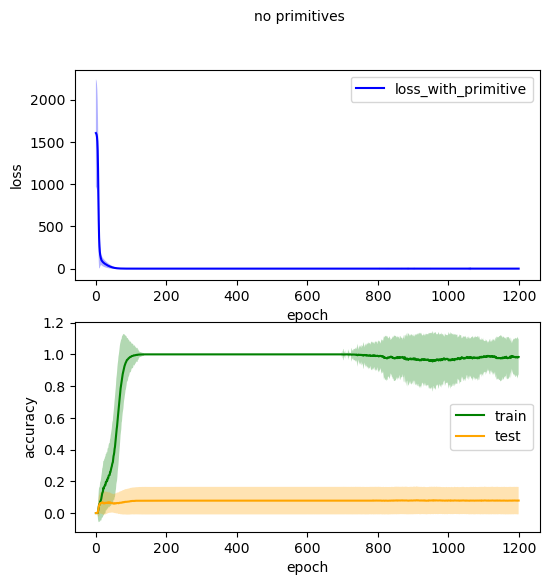

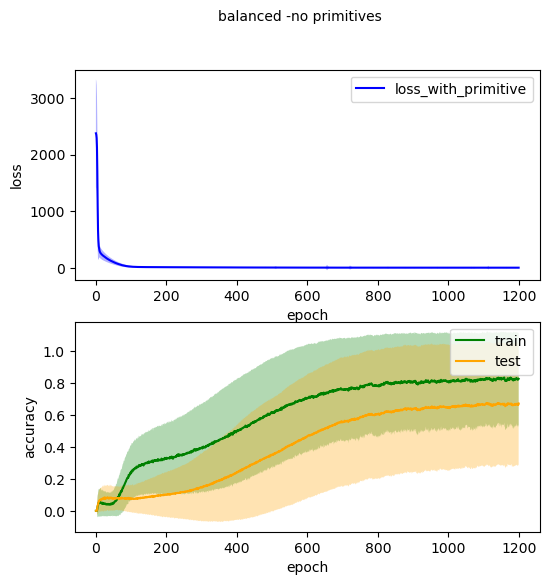

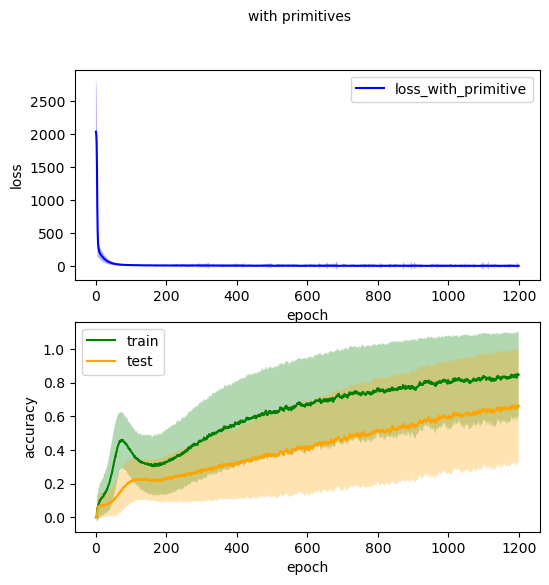

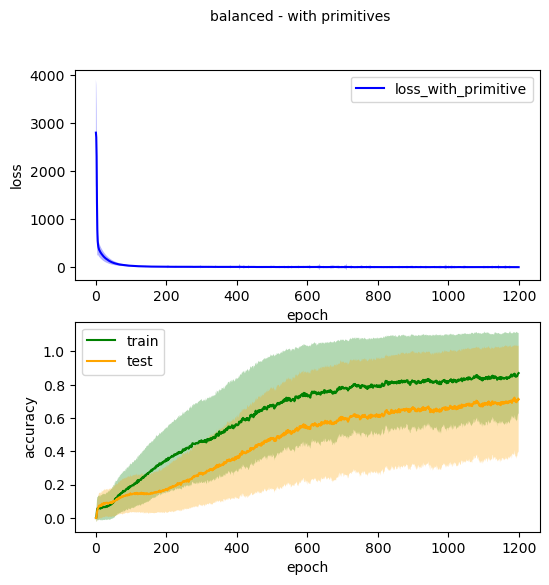

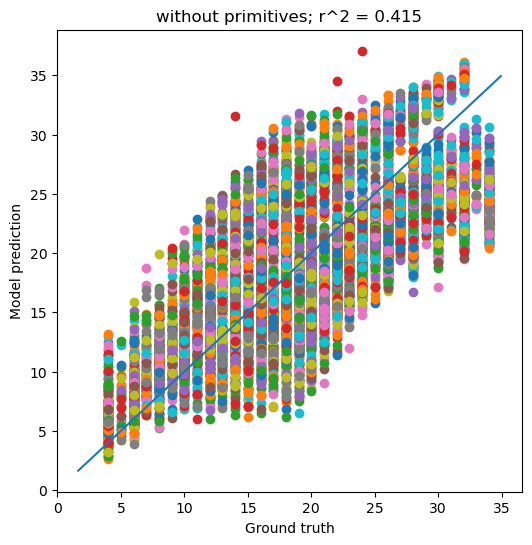

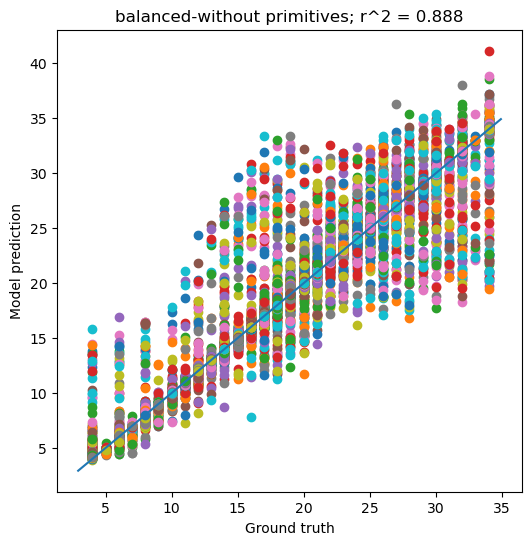

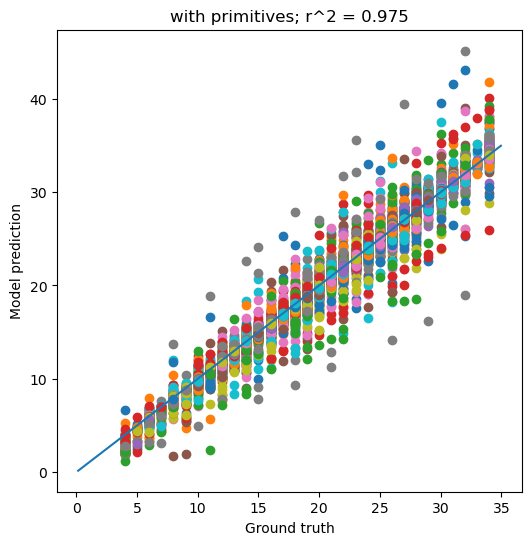

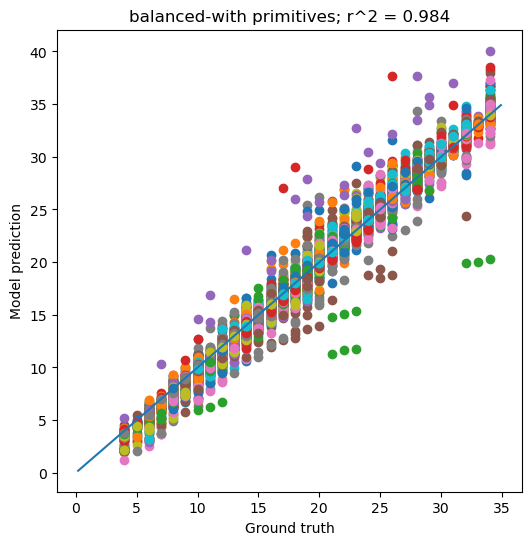

In [20]:
# run
num_sims=800
res1 = run_plot(trainseqs, trainseqs_b, trainseqs_p, trainseqs_bp, testseqs, cue_dict)

In [22]:
save_dir = '../results/addition_trigrams_4inputs_bp_800'
with open(save_dir, 'wb') as f:
    pickle.dump(res1, f)


In [14]:
testseq = generate_pos_trials(ops, all_syms, all_syms, cue_dict)

res_rdm = calculate_RDMs(res1, testseq, subset='all')

rdms = res_rdm['rdms']
rdms_p = res_rdm['rdms_p']
rdms_b = res_rdm['rdms_b']
rdms_bp = res_rdm['rdms_bp']
cue_dicts = res_rdm['ft_cue_dicts']
matlist = [np.array(rdms[t]).mean(axis=0) for t in range(4)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(4)]
matlist_b = [np.array(rdms_b[t]).mean(axis=0) for t in range(4)]
matlist_bp = [np.array(rdms_bp[t]).mean(axis=0) for t in range(4)]

no. 100% trained RNNs:  8


In [150]:
len(matlist)

4

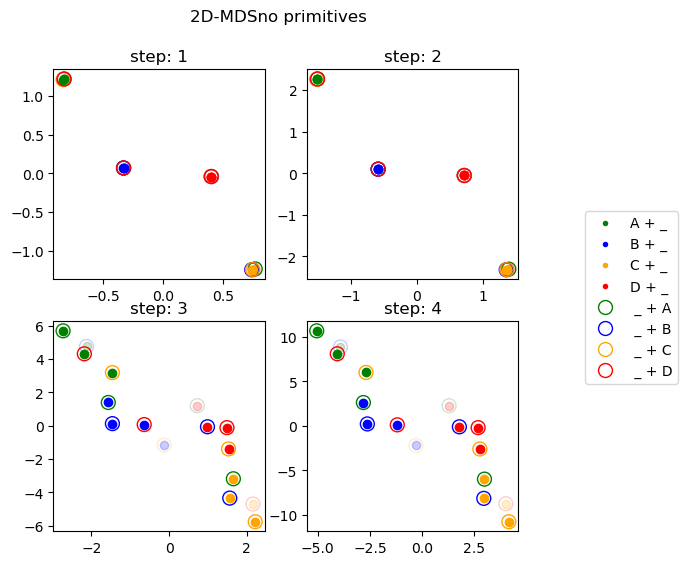

In [15]:
MDS_plot(matlist, testseq, trainseqs, title = 'no primitives')

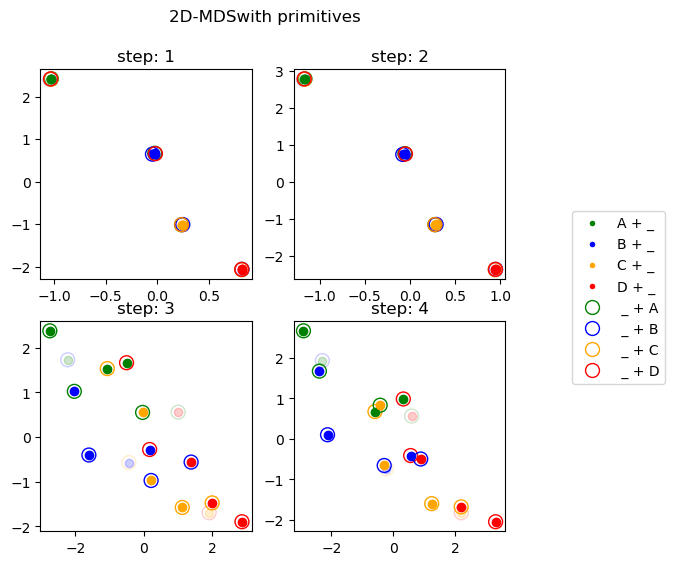

In [16]:
MDS_plot(matlist_p, testseq, trainseqs_p, title = 'with primitives')

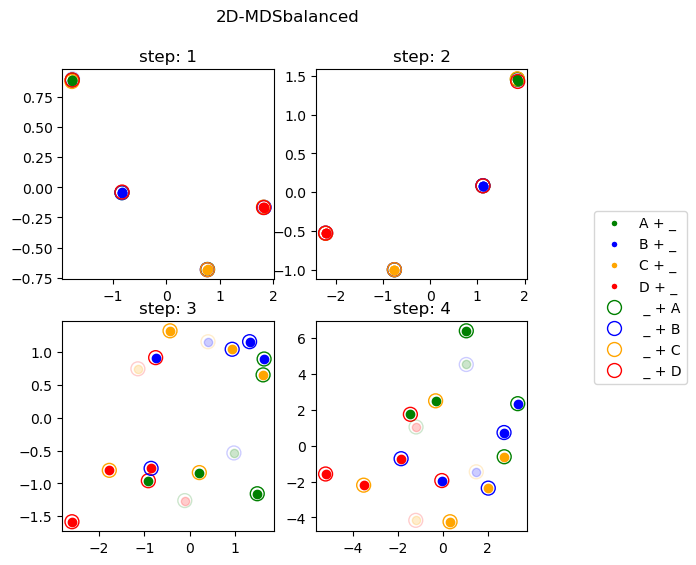

In [18]:
MDS_plot(matlist_b, testseq, trainseqs_b, title = 'balanced')

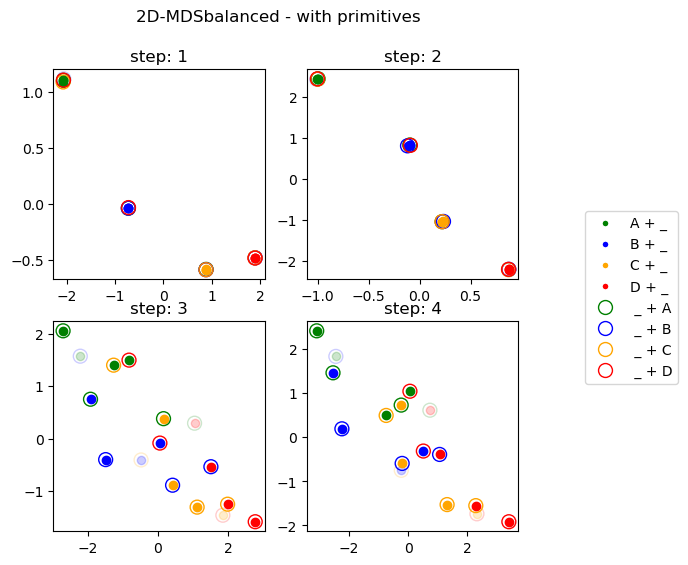

In [19]:
MDS_plot(matlist_bp, testseq, trainseqs_bp, title = 'balanced - with primitives')

In [147]:
def calculate_RDMs(res, testseq, subset = 'bp'):
    
    acc_df = res['acc_df']
    if subset == 'bp':
        all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_b'] == 1)&\
                              (acc_df['acc_train_bp'] == 1) & (acc_df['acc_train_p'] == 1)].index
    elif subset == 'all':
        all_acc_mods = acc_df.index
    print('no. 100% trained RNNs: ', len(all_acc_mods))
    mod_list = all_acc_mods # choose subset of rnns 

    rdms = [[] for _ in range(4)] # initialise empty lists/arrays
    rdms_p = [[] for _ in range(4)]
    rdms_b = [[] for _ in range(4)] # initialise empty lists/arrays
    rdms_bp = [[] for _ in range(4)]
    # extracts res1ults from dictionary
    mods = res1['mods']
    mods_p = res1['mods_p']
    mods_b = res1['mods_b']
    mods_bp = res1['mods_bp']

    cue_dicts = res1['cue_dicts']
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 

        testseqs = change_dict(testseq, cue_dicts[m])
        test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
        testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=False)

        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h+1,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)

        # get activations for primitive trained model
        hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h+1,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms_p[h].append(rep_mat)

        # get activations for control model
        hiddens_b, trials = get_reps(mods_b[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h+1,:] for hid in hiddens_b]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms_b[h].append(rep_mat)

        # get activations for primitive trained model
        hiddens_bp, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h+1,:] for hid in hiddens_bp])
            rep_mat = euclidean_distances(hid_vals)
            rdms_bp[h].append(rep_mat)

            
    return {'rdms': rdms, 'rdms_p': rdms_p, 'rdms_b': rdms_b, 'rdms_bp': rdms_bp, 'ft_cue_dicts': ft_cue_dicts}


In [137]:
def MDS_plot(matlist, testseqs, trainseqs, title = ''):
    
    valset = [t for t in testseqs if t not in trainseqs]
    valset_idx = [testseqs.index(val) for val in valset]
    
    colors2 = ['green', 'blue', 'orange', 'red']*4
    colors1 = ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5, label='A + _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='B + _'), 
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='C + _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='D + _'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'green', markerfacecolor='none', markersize=10, label=' _ + A'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'blue',markerfacecolor='none', markersize=10, label=' _ + B'), 
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'orange',markerfacecolor='none', markersize=10, label=' _ + C'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'red',markerfacecolor='none', markersize=10, label=' _ + D')]
    
    
    plt.rcParams['figure.figsize'] = 6, 6
    fig, axs = plt.subplots(2,2)

    for j, dist in enumerate(matlist):
        mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
        X_transform = mds.fit_transform(dist)
        ax = axs[math.floor(j/2), j%2]
        ax.title.set_text('step: '+str(j+1))
        for i in range(len(testseqs)):
            if i in valset_idx:
                alph = 1
            else:
                alph = 0.2
            ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
            ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

    plt.suptitle('2D-MDS'+title)
    fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5)) 
